In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.preprocessing import scale, robust_scale

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('coolwarm')
sns.set_color_codes('bright')

Feature Engineering

In [2]:
data = pd.read_csv('/Users/mahaksharma/Downloads/globalterrorismdb_0617dist.csv', encoding='latin1')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:

data = data[data['nkill'] <= 4].reset_index(drop=True)
data = data[data['nwound'] <= 7].reset_index(drop=True)

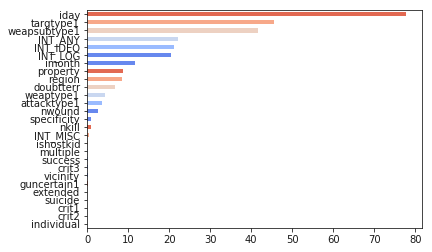

In [4]:
c = data.count().sort_values().drop([
    'eventid', 'country', 'iyear', 'natlty1', 'longitude', 'latitude', 'targsubtype1'])
_ = data[c[c > 100000].keys()].var().sort_values().plot.barh()

In [5]:
features = [
    'longitude',
    'latitude',
    
    'nwound',
    'nkill',
    
    'natlty1_txt',
    'targtype1_txt',
    'targsubtype1_txt',
    'weaptype1_txt',
    'attacktype1_txt',
]

X = pd.get_dummies(data[features])
X = X.T[X.var() > 0.05].T.fillna(0)
X = X.fillna(0)

print('Shape:', X.shape)
X.head()

Shape: (130560, 24)


,longitude,latitude,nwound,nkill,natlty1_txt_Afghanistan,natlty1_txt_India,natlty1_txt_Iraq,natlty1_txt_Pakistan,targtype1_txt_Business,targtype1_txt_Government (General),...,targsubtype1_txt_Unnamed Civilian/Unspecified,weaptype1_txt_Explosives/Bombs/Dynamite,weaptype1_txt_Firearms,weaptype1_txt_Incendiary,weaptype1_txt_Unknown,attacktype1_txt_Armed Assault,attacktype1_txt_Assassination,attacktype1_txt_Bombing/Explosion,attacktype1_txt_Facility/Infrastructure Attack,attacktype1_txt_Hostage Taking (Kidnapping)
0,-69.951164,18.456792,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-99.133207,19.432608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,120.599741,15.478598,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-89.176269,37.005105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-56.187214,-34.891151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


K-means clustering

2, 3, 4, 5, 6, 7, 8, 9, 10, 

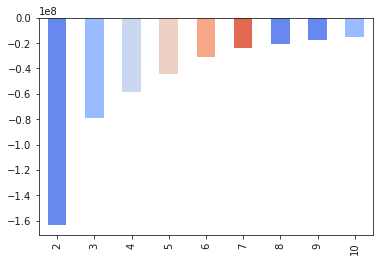

In [7]:
scores = {}
for k in range(2, 11):
    print(k, end=', ')
    scores[k] = KMeans(n_clusters=k).fit(X).score(X)
_ = pd.Series(scores).plot.bar()

In [8]:
data['Cluster'] = KMeans(n_clusters=6).fit_predict(X) + 1
print('Silhouette Score:', silhouette_score(X, data['Cluster'], sample_size=10000) * 10000 // 1 / 100, '%')

Silhouette Score: 59.08 %


k-means cluster selected using elbows method and silhouette obtained

Profiling

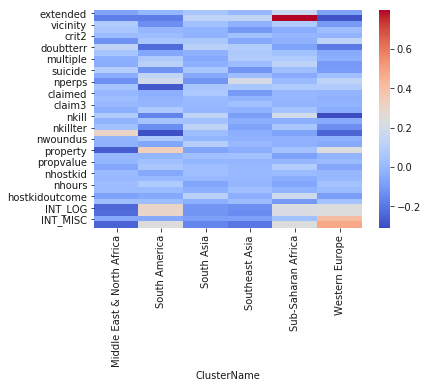

In [10]:
names = data.groupby('Cluster')['region_txt'].describe()['top'].values
data['ClusterName'] = data['Cluster'].apply(lambda c: names[c - 1])

numerical = data.dtypes[data.dtypes != 'object'].keys()
exclude = [
    'eventid', 'Cluster', 'region', 'country', 'iyear', 
    'natlty1', 'natlty2', 'natlty3', 'imonth', 'iday',
    'guncertain1', 'guncertain2', 'guncertain3'
] + [col for col in numerical if 'type' in col or 'mode' in col or 'ransom' in col]
X_profiling = data[numerical.drop(exclude)].fillna(0)
X_profiling = pd.DataFrame(scale(X_profiling), columns=X_profiling.columns)
X_profiling['ClusterName'] = data['ClusterName']
_ = sns.heatmap(X_profiling.groupby('ClusterName').mean().drop(['longitude', 'latitude'], axis=1).T, 
               cmap='coolwarm')

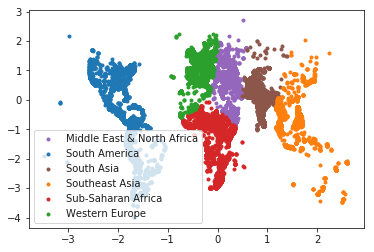

In [11]:
ckeys = data['ClusterName'].unique()
ckeys = dict(zip(ckeys, plt.cm.tab10(range(len(ckeys)))))

for i, x in X_profiling.groupby('ClusterName'):
    _ = plt.scatter(x['longitude'], x['latitude'], c=ckeys[i], marker='.', cmap='tab10', label=i)
_ = plt.legend(loc=3)


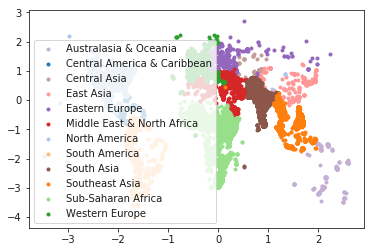

In [12]:
ckeys = data['region_txt'].unique()
ckeys = dict(zip(ckeys, plt.cm.tab20(range(len(ckeys)))))

for i, x in pd.concat([X_profiling, data['region_txt']], axis=1).groupby('region_txt'):
    _ = plt.scatter(x['longitude'], x['latitude'], c=ckeys[i], marker='.', cmap='tab10', label=i)
_ = plt.legend(loc=3)

In [13]:
print('Similarity between cluster and region labels:', 
      len(data[data['region_txt'] == data['ClusterName']]) / len(data) * 10000 // 1 / 100, '%')

Similarity between cluster and region labels: 83.21 %


Cluster profiles based on attributes
ATTACK TYPE

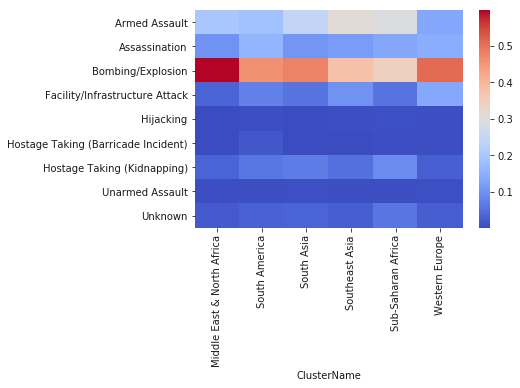

In [14]:
d = pd.get_dummies(data['attacktype1_txt'])
d['ClusterName'] = data['ClusterName']
_ = sns.heatmap(d.groupby('ClusterName').mean().T, cmap='coolwarm')

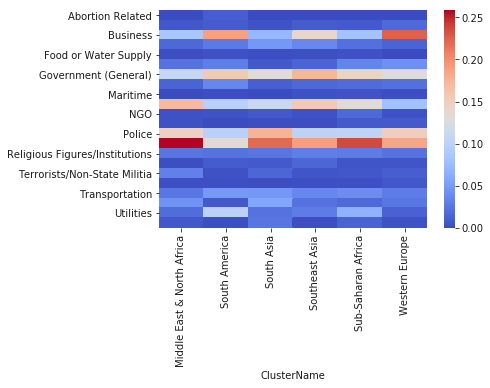

In [15]:
d = pd.get_dummies(data['targtype1_txt'])
d['ClusterName'] = data['ClusterName']
_ = sns.heatmap(d.groupby('ClusterName').mean().T, cmap='coolwarm')

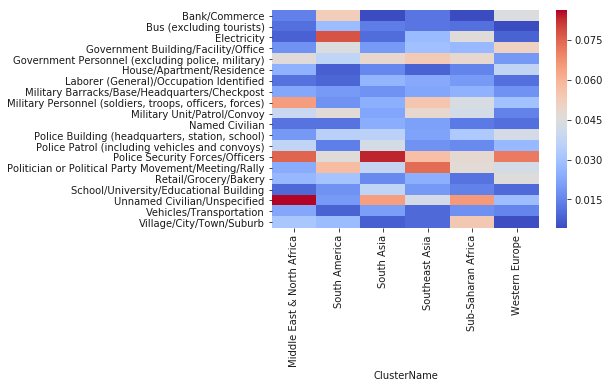

In [16]:
top = data['targsubtype1_txt'].value_counts().head(20).keys().tolist()
d = pd.get_dummies(data['targsubtype1_txt'].apply(lambda x: x if x in top else None))
d['ClusterName'] = data['ClusterName']
_ = sns.heatmap(d.groupby('ClusterName').mean().T, cmap='coolwarm')

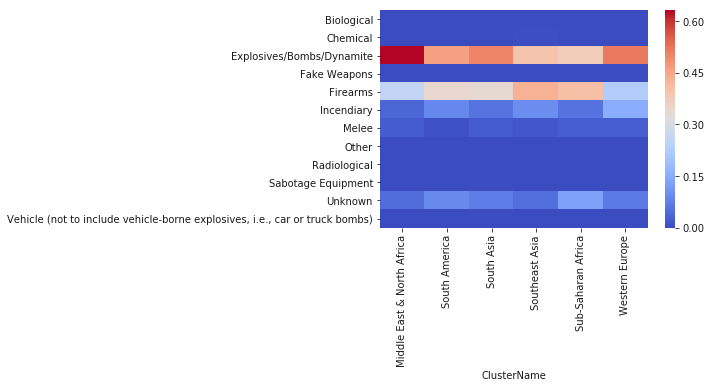

In [17]:
d = pd.get_dummies(data['weaptype1_txt'])
d['ClusterName'] = data['ClusterName']
_ = sns.heatmap(d.groupby('ClusterName').mean().T, cmap='coolwarm')

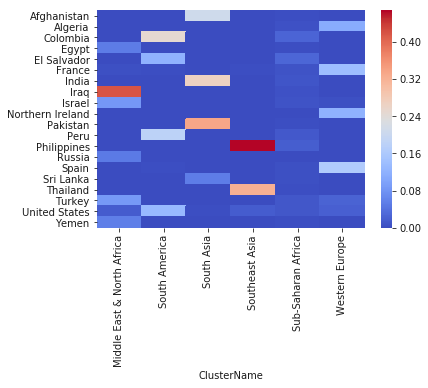

In [18]:
top_natls = data['natlty1_txt'].value_counts().head(20).keys()
natl = data['natlty1_txt'].apply(lambda x: x if x in top_natls else None)
d = pd.get_dummies(natl)
d['ClusterName'] = data['ClusterName']
_ = sns.heatmap(d.groupby('ClusterName').mean().T, cmap='coolwarm')

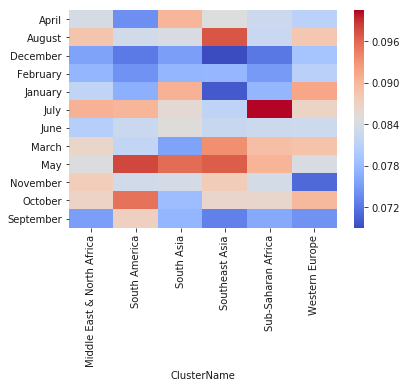

In [19]:
months = ['', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
d = pd.get_dummies(data['imonth'].apply(lambda x: None if x == 0 else months[int(x)]))
d['ClusterName'] = data['ClusterName']
_ = sns.heatmap(d.groupby('ClusterName').mean().T, cmap='coolwarm')

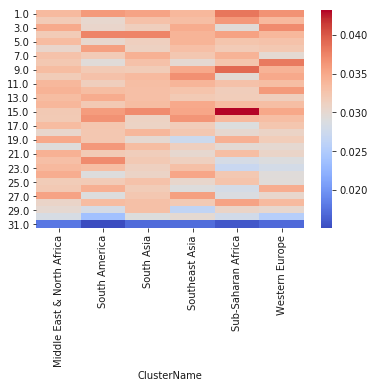

In [20]:
d = pd.get_dummies(data['iday'].apply(lambda x: None if x == 0 else int(x)))
d['ClusterName'] = data['ClusterName']
_ = sns.heatmap(d.groupby('ClusterName').mean().T, cmap='coolwarm')

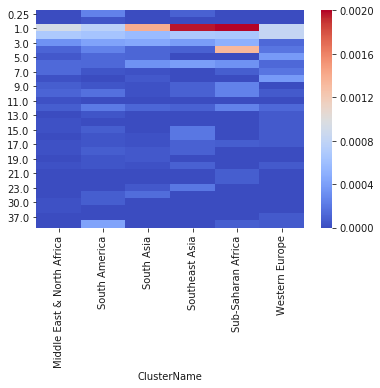

In [21]:
d = pd.get_dummies(data['nhours'].apply(lambda x: None if x <= 0 else x))
d['ClusterName'] = data['ClusterName']
_ = sns.heatmap(d.groupby('ClusterName').mean().T, cmap='coolwarm')


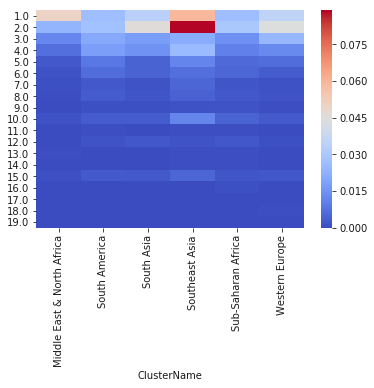

In [22]:
d = pd.get_dummies(data['nperps'].apply(lambda x: None if (x <= 0 or x >= 20) else x))
d['ClusterName'] = data['ClusterName']
_ = sns.heatmap(d.groupby('ClusterName').mean().T, cmap='coolwarm')